In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cellpose import models
from cellpose.io import imread
import glob
from pathlib import Path
from PIL import Image, ImageSequence
from tqdm import tqdm
import os
import os.path
from livecell_tracker import segment
from livecell_tracker import core
from livecell_tracker.core import datasets
from livecell_tracker.core.datasets import LiveCellImageDataset, SingleImageDataset
from skimage import measure
from livecell_tracker.core import SingleCellTrajectory, SingleCellStatic
import detectron2
from detectron2.utils.logger import setup_logger

setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
import cv2

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from livecell_tracker.segment.detectron_utils import gen_cfg

from livecell_tracker.segment.detectron_utils import (
    segment_detectron_wrapper,
    segment_images_by_detectron,
    convert_detectron_instance_pred_masks_to_binary_masks,
    convert_detectron_instances_to_label_masks,
)
from livecell_tracker.segment.detectron_utils import (
    convert_detectron_instance_pred_masks_to_binary_masks,
    convert_detectron_instances_to_label_masks,
    segment_images_by_detectron,
    segment_single_img_by_detectron_wrapper,
)


## Loading single cells from existing mask files

```LiveCellImageDataset, SingleCellImageDataset``` from livecell_tracker.core.datasets allow users to load images with ease, without reading directly into memories.  
In `mask_dataset_path` please make sure that the sorted (alphabetically) file names correspond to the order of times.
 Note that the sorted mechanism provided is simply sort the url (file name) list according to string value. Please note that without proper left trailing zeroes, the order of final times may be incorrect. E.g. string  `T10` (10th file) is less than string `T2`. If you have your customized file patterns, please provide `LiveCellImageDataset` with a `time2url` dictionary to provide necessary time information mapped to file locations for reading time-lapsed data.
`SingleCellImageDataset` takes a single image from the memory and makes it a single time point dataset, which can be handy when you would like to process imaging datasets. 

In [2]:
dataset_dir_path = Path(
    "../datasets/test_data_STAV-A549/DIC_data"
)

mask_dataset_path = Path("../datasets/test_data_STAV-A549/mask_data")

In [3]:
mask_dataset = LiveCellImageDataset(mask_dataset_path, ext="png")
mask_dataset.time2url

3 png img file paths loaded: 


{0: '../datasets/test_data_STAV-A549/mask_data/seg_STAV-A549_VIM_24hours_NoTreat_NA_YL_Ti2e_2022-12-21_T252_XY01_DIC.tif.png',
 1: '../datasets/test_data_STAV-A549/mask_data/seg_STAV-A549_VIM_24hours_NoTreat_NA_YL_Ti2e_2022-12-21_T253_XY01_DIC.tif.png',
 2: '../datasets/test_data_STAV-A549/mask_data/seg_STAV-A549_VIM_24hours_NoTreat_NA_YL_Ti2e_2022-12-21_T254_XY01_DIC.tif.png'}

In [4]:
dic_dataset = LiveCellImageDataset(dataset_dir_path, ext="tif")

3 tif img file paths loaded: 


In [5]:
dic_dataset.time2url

{0: '../datasets/test_data_STAV-A549/DIC_data/STAV-A549_VIM_24hours_NoTreat_NA_YL_Ti2e_2022-12-21_T252_XY01_DIC.tif',
 1: '../datasets/test_data_STAV-A549/DIC_data/STAV-A549_VIM_24hours_NoTreat_NA_YL_Ti2e_2022-12-21_T253_XY01_DIC.tif',
 2: '../datasets/test_data_STAV-A549/DIC_data/STAV-A549_VIM_24hours_NoTreat_NA_YL_Ti2e_2022-12-21_T254_XY01_DIC.tif'}

Convert label masks to single objects

In [6]:
from skimage.measure import regionprops
from livecell_tracker.segment.utils import mask_dataset_to_single_cells

single_cells = mask_dataset_to_single_cells(mask_dataset, dic_dataset)



In [7]:
# for testing
# single_cells = single_cells[:10]

In [8]:
len(single_cells)

42

In [9]:
single_cells_by_time = {}
for cell in single_cells:
    if cell.timeframe not in single_cells_by_time:
        single_cells_by_time[cell.timeframe] = []
    single_cells_by_time[cell.timeframe].append(cell)

In [10]:
for time in single_cells_by_time:
    print(time, len(single_cells_by_time[time]))

0 13
1 14
2 15


Visualize one single cell

<AxesSubplot: >

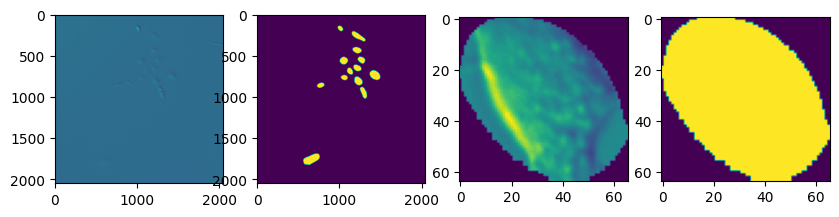

In [11]:
sc = single_cells[0]

fig, axes = plt.subplots(1, 4, figsize=(10, 5))
sc.show(ax=axes[0])
sc.show_mask(ax=axes[1])
sc.show_contour_img(ax=axes[2])
sc.show_contour_mask(ax=axes[3])

In [12]:
sc1 = single_cells[1]
sc2 = single_cells[2]

In [13]:
from livecell_tracker.trajectory.feature_extractors import compute_skimage_regionprops

skimage_features = compute_skimage_regionprops(sc1)
sc1.add_feature("skimage", skimage_features)

In [14]:
sc1.get_feature_pd_series()

skimage_area                  9375.000000
skimage_area_bbox            20916.000000
skimage_area_convex           9728.000000
skimage_area_filled           9375.000000
skimage_axis_major_length      199.544403
                                 ...     
skimage_orientation              1.008517
skimage_perimeter              472.457936
skimage_perimeter_crofton      450.599728
skimage_solidity                 0.963713
t                                0.000000
Length: 148, dtype: float64

Calculate overlap between two single cells

In [15]:
sc1.compute_iou(sc2), sc1.compute_overlap_percent(sc2)

(0.0, 0.0)

## Tracking based on single cells

In [16]:
from typing import List
from livecell_tracker.track.sort_tracker_utils import (
    gen_SORT_detections_input_from_contours,
    update_traj_collection_by_SORT_tracker_detection,
    track_SORT_bbox_from_contours
)

def track_SORT_bbox_from_scs(
    single_cells: List[SingleCellStatic],
    raw_imgs: LiveCellImageDataset,
    max_age=5,
    min_hits=3,
):
    url2contours = {}
    for sc in single_cells:
        timeframe = sc.timeframe
        if not (raw_imgs.get_img_path(timeframe) in url2contours):
            url2contours[raw_imgs.get_img_path(timeframe)] = {
                "contours": [],
            }
        url2contours[raw_imgs.get_img_path(timeframe)]["contours"].append(sc.contour)
    return track_SORT_bbox_from_contours(url2contours, raw_imgs, max_age, min_hits)

traj_collection = track_SORT_bbox_from_scs(single_cells, dic_dataset, max_age=1, min_hits=1)

matching image path: ../datasets/test_data_STAV-A549/DIC_data/STAV-A549_VIM_24hours_NoTreat_NA_YL_Ti2e_2022-12-21_T252_XY01_DIC.tif
matching image path: ../datasets/test_data_STAV-A549/DIC_data/STAV-A549_VIM_24hours_NoTreat_NA_YL_Ti2e_2022-12-21_T253_XY01_DIC.tif
matching image path: ../datasets/test_data_STAV-A549/DIC_data/STAV-A549_VIM_24hours_NoTreat_NA_YL_Ti2e_2022-12-21_T254_XY01_DIC.tif


<AxesSubplot: ylabel='Count'>

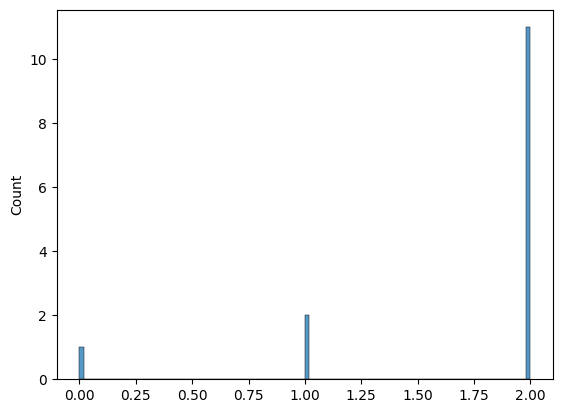

In [17]:
traj_collection.hist_traj_length()

In [18]:
%gui qt
from livecell_tracker.core.napari_visualizer import NapariVisualizer
import napari
from skimage import data
# viewer = napari.view_image(raw_imgs[0], name='image')
viewer = napari.view_image(dic_dataset.to_dask(), name='image', cache=True)
shape_layer = NapariVisualizer.viz_traj_collection(traj_collection, viewer)

Cannot move to target thread (0x6d921f0)



: 

: 